## Example 1: Nonconvex Minimax Problems without Constraints.
We consider the following possibly nonconvex-nonconcave minimax problem:
\begin{equation}
\min_{u \in \mathbb{R}^{p_1}}\max_{v\in\mathbb{R}^{p_2}}\Big\{ \mathcal{L}(u,v) = f(u) + \frac{1}{n}\sum_{i=1}^n\big[u^{\top}A_iu + u^{\top}L_iv - v^{\top}B_iv + b_i^{\top}u - c_i^{\top}v\big] - g(v) \Big\},
\end{equation}
where $A_i \in\mathbb{R}^{p_1\times p_1}$ and $B_i \in \mathbb{R}^{p_2\times p_2}$ are symmetric matrices, $b_i \in\mathbb{R}^{p_1}$, $c_i \in\mathbb{R}^{p_2}$, and $L_i \in \mathbb{R}^{p_1\times p_2}$ is a given matrix.
Here, we add two terms $f(u)$ and $g(v)$ to possibly handle constraints or regularizers associated with $u$ and $v$, respectively.

In this experiment, we consider the case $f = 0$ and $g=0$, without constraints. The optimality condition of the minimax problem reduces to $G(x) = 0$ as a linear equation.

In [45]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import random
import scipy as sci
import solvers.ne_solvers as solver
import solvers.ame_solvers as acc_solver

## Linear Operator $G(x)$
Define the perator $G(x) := [Au + Lv + b, -L^{\top}u + Bv + c]$ for our experiments, where $A := \frac{1}{n}\sum_{i=1}^nA_i$, $B := \frac{1}{n}\sum_{i=1}^nB_i$, $L := \frac{1}{n}\sum_{i=1}^nL_i$, $b := \frac{1}{n}\sum_{i=1}^nb_i$, and $c := \frac{1}{n}\sum_{i=1}^nc_i$.

In [46]:
def G_op_eval(data, x, mb_id, mb_size):
    """
    -- Define the operator G for our methods
    -- Args: data, x=x(k), mb_id=the indices of minibatch-size, mb_size=the size of mini-batch.
    -- Returns: G(x).
    """
    K = data.get("K")
    b = data.get("b")
    return np.mean([K[i].dot(x) + b[i] for i in mb_id], axis=0)

def Gb_op_eval(data, x, mb_id, mb_size):
    """
    -- Define the operator G and also output the output components.
    """
    K   = data.get("K")
    b   = data.get("b")
    y_b = [K[i].dot(x) + b[i] for i in mb_id]
    return np.mean(y_b, axis=0), y_b

## Generate Data for Our Experiments

In [47]:
def generate_data(n, p):
    
    # generate a symmetric matrix.
    p1 = int(p/2)
    p2 = p-p1
    K, b = [], []
    K_sum = []
    LB_value = 0.0
    for i in range(n):
        # Generate KKT matrix
        D1  = np.maximum(np.diag(np.random.randn(p1)), LB_value)
        #D1  = D1/np.sum(D1, axis=1, keepdims=True)
        Q1, _ = la.qr(np.random.randn(p1, p1))
        Ai = np.matmul(np.matmul(Q1, D1), Q1.T)
        
        D2  = np.maximum(np.diag(np.random.randn(p2)), LB_value)
        #D2  = D2/np.sum(D2, axis=1, keepdims=True)
        Q2, _ = la.qr(np.random.randn(p2, p2))
        Bi = np.matmul(np.matmul(Q2, D2), Q2.T)
        
        Li = np.random.randn(p1,p2)
        #Li = Li/np.sum(Li, axis=1, keepdims=True)
        
        Ki = np.block([[Ai,  Li], [-Li, Bi]])
        ##Ki = Ki/np.sum(Ki, axis=1, keepdims=True)
        ##Ki = Ki/la.norm(Ki, ord=2)
    
        # generate bi.
        bi = np.random.randn(p)
        #bi = bi/np.sum(bi)
        
        K.append(Ki)
        b.append(bi)
        if i==0:
            K_sum = Ki
        else:
            K_sum = K_sum + Ki
            
    K_sum = (1/n)*K_sum
    Lips = la.norm(K_sum, ord=2)    
    my_data = dict({"K": K, "b": b, "n": n, "p": p, "L": Lips})
    print("The Lipschitz constant:", Lips)
    
    ## general an initial point.
    x0 = np.random.randn(p)
    
    # return results.
    return my_data, x0

## Prepare to Run All Algorithm at once

In [48]:
def OneRun(my_data, x0):
    ## check the problem size.
    print("Problem size: n = ", my_data.get('n'), ", p = ", my_data.get('p'))

    ## Extract information from the data.
    Lips = my_data.get("L")
    n    = my_data.get("n")
    p    = my_data.get("p")
    
    ## set default parameters
    def_gamma        = 0.75
    def_lr           = 0.5
    def_max_iters    = 10000
    def_tol          = 1e-20
    def_n_max_epochs = 100
    def_mb_size      = int(n**0.67)
    my_is_term       = False  ## using termination condition or not.
    my_verbose       = 0
    output_all       = []

    ## Optimistic gradient method
    my_max_iters = def_n_max_epochs
    my_lr1       = 1.0/(2.0*my_data.get("L"))
    print("Learning rate: ", my_lr1)
    output1      = solver.OG(my_data, G_op_eval, x0, gamma=0.5, eta=my_lr1,\
                             verbose=my_verbose, n_max_iters=my_max_iters,\
                             tol=def_tol, is_term = my_is_term)
    print("Solver status (DetOG)   :", output1["message"])
    output_all.append(output1)
        
    ## Accelerated optimistic gradient method
    my_max_iters2 = def_n_max_epochs
    my_lr2        = 1.0/(2.0*my_data.get("L"))
    my_shift2     = 10.0
    print("Learning rate: ", my_lr2)
    output2       = acc_solver.AOG(my_data, G_op_eval, x0, beta=my_lr2, r_shift=my_shift2, \
                                   verbose=my_verbose, n_max_iters=my_max_iters2,\
                                   tol=def_tol, is_term = my_is_term)
    print("Solver status (DetAcOG) :", output2["message"])
    output_all.append(output2)

    ## SAGA-Root-Finding method from Davis' paper
    my_mb_size3 = int(0.5*n**0.67) # default
    my_lr3      = 0.25/my_data.get("L")
    print("Learning rate: ", my_lr3)
    output3     = solver.SagaRF(my_data, G_op_eval, Gb_op_eval, x0, mb_size=my_mb_size3, \
                                eta=my_lr3, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                                tol=def_tol, is_term = my_is_term)
    print("Solver status (SagaVrRF):", output3["message"])
    output_all.append(output3)

    ## SVRG Forward-Reflected-Backward Splitting Method
    my_prob4    = 1.0/(n**0.33)    # default value
    my_mb_size4 = int(0.5*n**0.67) # default value
    # Theoretical learning rate
    my_lr4      = 5.0 * 0.99*(1 - np.sqrt(1-my_prob4))/(2.0*my_data.get("L"))
    print("Learning rate: ", my_lr4)
    output4     = solver.VrFRBS(my_data, G_op_eval, x0, mb_size=my_mb_size4, prob=my_prob4, \
                                eta=my_lr4, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                                tol=def_tol, is_term = my_is_term)
    print("Solver status (SvrgFRBS):", output4["message"])
    output_all.append(output4)
    
    ## SVRG Extragradient method
    my_prob5    = np.minimum(1.0/(n**0.33), 0.99) # default value
    my_mb_size5 = int(0.5*n**0.67) # default value
    my_alpha5   = 1 - my_prob5 
    my_lr5      = 0.99*np.sqrt(1-my_alpha5)/my_data.get("L")
    print("Learning rate: ", my_lr5)
    output5     = solver.VrEG(my_data, G_op_eval, x0, mb_size=my_mb_size5, prob=my_prob5, \
                              eta=my_lr5, alpha=my_alpha5, verbose=my_verbose, n_epochs=def_n_max_epochs,\
                              tol=def_tol, is_term = my_is_term)
    print("Solver status (SvrgEG):  ", output5["message"])
    output_all.append(output5)
    
    ## Accelerated SVRG-Forward Reflected method
    my_mb_size6 = int(0.5*n**0.67)  # default value
    my_prob6    = 1.0/(n**0.33)     # default value
    my_lr6      = 0.15 / my_data.get("L") 
    my_shift6   = 20.0
    print("Learning rate: ", my_lr6)
    output6     = acc_solver.SvrgAcFR(my_data, G_op_eval, x0, mb_size=my_mb_size6, \
                                    beta=my_lr6, verbose=my_verbose, r_shift = my_shift6, \
                                    n_epochs=def_n_max_epochs, tol=def_tol, is_term = my_is_term)
    print("Solver status (SvrgAcFR):", output6["message"])
    output_all.append(output6)
    
    ## Accelerated SAGA-FR method.
    my_mb_size7 = int(0.5*n**0.67) # default value
    my_lr7      = 0.25 / my_data.get("L")
    my_shift7   = 20.0
    print("Learning rate: ", my_lr7)
    output7     = acc_solver.SagaAcFR(my_data, G_op_eval, Gb_op_eval, x0, mb_size=my_mb_size7, beta=my_lr7, \
                                  r_shift = my_shift7, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                                  tol=def_tol, is_term = my_is_term)
    print("Solver status (SagaAcFR):", output7["message"])
    output_all.append(output7)

    # return all outputs
    return output_all


## Run Experiment 1

In [49]:
## Experiment 1
print("************************ We are running Experiment 1 ... ************************")
n1, p1 = 5000, 100
n_num_of_runs = 10
experiment1 = []
for n_run in range(n_num_of_runs):
    print("=======> We are running time ", n_run, " of Experiment 1")
    my_data1, x0 = generate_data(n1, p1)
    output1 = OneRun(my_data, x0)
    experiment1.append(output1)
print("Finished!")

************************ We are running Experiment 1 ... ************************
=======> We are running time  0  of Experiment 1
The Lipschitz constant: 0.538001750827387
Problem size: n =  5000 , p =  100
Learning rate:  0.9226346517257514
Solver status (DetOG)   : Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.9226346517257514
Solver status (DetAcOG) : Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.4613173258628757
Solver status (SagaVrRF): Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.13951780760324822
Solver status (SvrgFRBS): Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.4480896380421147
Solver status (SvrgEG):   Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.27679039551772544
Solver status (SvrgAcFR): Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  

## Run Experiment 2

In [50]:
## Experiment 2
print("************************ We are running Experiment 2 ... ************************")
n2, p2 = 10000, 200
n_num_of_runs = 10
experiment2 = []
for n_run in range(n_num_of_runs):
    print("=======> We are running time ", n_run, " of Experiment 2")
    my_data2, x0_2 = generate_data(n2, p2)
    output2 = OneRun(my_data2, x0_2)
    experiment2.append(output2)
print("Finished!")

************************ We are running Experiment 2 ... ************************
=======> We are running time  0  of Experiment 2
The Lipschitz constant: 0.5422886230369549
Problem size: n =  10000 , p =  200
Learning rate:  0.9220182367092125
Solver status (DetOG)   : Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.9220182367092125
Solver status (DetAcOG) : Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.46100911835460623
Solver status (SagaVrRF): Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.11056233658754482
Solver status (SvrgFRBS): Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.39939691074110184
Solver status (SvrgEG):   Exceed the maximum number of epochs. Increase it to run further ...
Learning rate:  0.2766054710127637
Solver status (SvrgAcFR): Exceed the maximum number of epochs. Increase it to run further ...
Learning rate

## Plot the results of Experiment 1 and Experiment 2

In [56]:
## For Exmperiment 1.
n_algs = len(experiment1[0])
iter_all1, op_norm_all1 = [], []
for k in range(n_algs):
    iter_run, op_norm_run = [], []
    for i in range(n_num_of_runs):
        output_all1 = experiment1[i]
        output_tmp1 = output_all1[k]
        iter_run.append( [h.get("epoch") for h in output_tmp1.get("epoch_hist")] )
        op_norm_run.append( [h.get("op_norm") for h in output_tmp1.get("epoch_hist")] )
    iter_all1.append(iter_run)
    op_norm_all1.append(op_norm_run)

## Compute the mean value of the iterate.
avg_iter1, avg_norm_un1 = [], []
for k in range(n_algs):
    avg_iter1.append( np.mean(iter_all1[k], axis=0) )
    avg_norm_un1.append( np.array(op_norm_all1[k]) )

## Compute the mean value of the norm.
avg_norm_n1 = []
for k in range(n_algs):
    avg_norm_n1.append( np.mean(avg_norm_un1[k], axis=0)  )

## Normalize
avg_norm_f1 = []
for k in range(n_algs):
    tmp = avg_norm_n1[k]
    avg_norm_f1.append( tmp / np.maximum(1, tmp[0]) )
    

In [57]:
## For Exmperiment 2.
n_algs = len(experiment2[0])
iter_all2, op_norm_all2 = [], []
for k in range(n_algs):
    iter_run, op_norm_run = [], []
    for i in range(n_num_of_runs):
        output_all2 = experiment2[i]
        output_tmp2 = output_all2[k]
        iter_run.append( [h.get("epoch") for h in output_tmp2.get("epoch_hist")] )
        op_norm_run.append( [h.get("op_norm") for h in output_tmp2.get("epoch_hist")] )
    iter_all2.append(iter_run)
    op_norm_all2.append(op_norm_run)

## Compute the mean value of the iterate.
avg_iter2, avg_norm_un2 = [], []
for k in range(n_algs):
    avg_iter2.append( np.mean(iter_all2[k], axis=0) )
    avg_norm_un2.append( np.array(op_norm_all2[k]) )

## Compute the mean value of the norm.
avg_norm_n2 = []
for k in range(n_algs):
    avg_norm_n2.append( np.mean(avg_norm_un2[k], axis=0)  )

## Normalize
avg_norm_f2 = []
for k in range(n_algs):
    tmp = avg_norm_n2[k]
    avg_norm_f2.append( tmp / np.maximum(1, tmp[0]) )
    

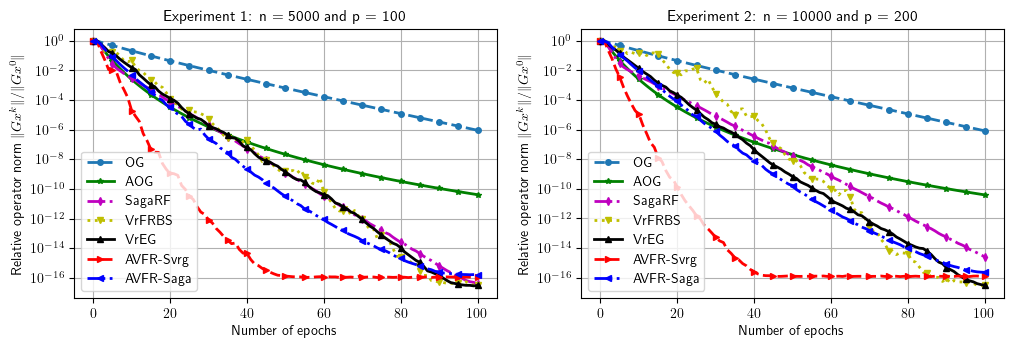

In [60]:
## Now we plot the results.
p_e1, n_e1  = p1, n1
p_e2, n_e2  = p2, n2

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))
plt.rc('text', usetex=True)
alg_names = ['OG', 'AOG', 'SagaRF', 'VrFRBS', 'VrEG', 'AVFR-Svrg', 'AVFR-Saga']
l_colors   = ['C0', 'g', 'm', 'y', 'k', 'r', 'b', 'C1', 'C2']
l_line_styles = ['--', '-', '-.', ':', '-', '--', '-.', '-', '--']
l_markers = ['o', '*', 'd', 'v', '^', '>', '<', 's', 'o']

for k in range(n_algs):
    axs[0].semilogy(avg_iter1[k], avg_norm_f1[k], marker= l_markers[k], linewidth=2, linestyle=l_line_styles[k], color=l_colors[k], \
                    markersize=4, markevery=5, label=alg_names[k]);   
axs[0].set_title("Experiment 1: n = " + str(n_e1) + " and p = " + str(p_e1), fontsize=11)
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Relative operator norm $\Vert Gx^k \Vert/\Vert Gx^0\Vert$')

for k in range(n_algs):
    axs[1].semilogy(avg_iter2[k], avg_norm_f2[k], marker= l_markers[k], linewidth=2, linestyle=l_line_styles[k], color=l_colors[k], \
                    markersize=4, markevery=5, label=alg_names[k]);   
axs[1].set_title("Experiment 2: n = " + str(n_e2) + " and p = " + str(p_e2), fontsize=11)
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Relative operator norm $\Vert Gx^k\Vert/\Vert Gx^0\Vert$')

plt.show()
fig.savefig("figs/minimax4ne_experiment1_and_2_7algs.pdf", format="pdf")

